## About

In this notebook we prepare a simple solution for the [kaggle challenge on higgs.](https://inclass.kaggle.com/c/mlhep-2016-higgs-detection)

In [1]:
%matplotlib inline

In [243]:
!pip install --upgrade sklearn

    100% |################################| 17.6MB 68kB/s 
  Running setup.py bdist_wheel for sklearn ... - done
  Stored in directory: /root/.cache/pip/wheels/d7/db/a3/1b8041ab0be63b5c96c503df8e757cf205c2848cf9ef55f85e
Successfully built sklearn
  Found existing installation: scikit-learn 0.16.1
    DEPRECATION: Uninstalling a distutils installed project (scikit-learn) has been deprecated and will be removed in a future version. This is due to the fact that uninstalling a distutils project will only partially uninstall the project.
    Uninstalling scikit-learn-0.16.1:
      Successfully uninstalled scikit-learn-0.16.1
You are using pip version 8.1.1, however version 8.1.2 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:

import matplotlib.pyplot as plt

import pandas
import numpy

from sklearn.cross_validation import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.svm import LinearSVC
from sklearn.datasets import load_iris
from sklearn.feature_selection import SelectFromModel

### Download data

In [3]:
!cd datasets; wget -O public_train_10000.root -nc --no-check-certificate https://2016.mlhep.yandex.net/data/higgs/public_train_10000.root

wget: /root/miniconda/envs/rep_py2/lib/libcrypto.so.1.0.0: no version information available (required by wget)
wget: /root/miniconda/envs/rep_py2/lib/libssl.so.1.0.0: no version information available (required by wget)
File `public_train_10000.root' already there; not retrieving.


In [4]:
# you can download training sample with 100000 available events
# uncomment the below row
# !cd datasets; wget -O public_train_100000.root -nc --no-check-certificate https://2016.mlhep.yandex.net/data/higgs/public_train_100000.root

In [5]:
!cd datasets; wget -O public_test.root -nc --no-check-certificate https://2016.mlhep.yandex.net/data/higgs/public_test.root

wget: /root/miniconda/envs/rep_py2/lib/libcrypto.so.1.0.0: no version information available (required by wget)
wget: /root/miniconda/envs/rep_py2/lib/libssl.so.1.0.0: no version information available (required by wget)
File `public_test.root' already there; not retrieving.


### Read the smallest part of training file and test file

In [6]:
import root_numpy
data = pandas.DataFrame(root_numpy.root2array('datasets/public_train_10000.root'))
test = pandas.DataFrame(root_numpy.root2array('datasets/public_test.root'))

In [7]:
data.head()

,event_id,target,lepton_pt,lepton_eta,lepton_phi,mem_pt,mem_phi,jet1_pt,jet1_eta,jet1_phi,...,jet4_eta,jet4_phi,jet4_btag,m_jj,m_jjj,m_lv,m_jlv,m_bb,m_wbb,m_wwbb
0,1000001,1,34.750568,0.787025,1.898891,20.862434,-2.622998,44.814148,-0.168171,2.631595,...,0.877472,-0.256736,0.000000,81.724449,189.583145,80.118317,170.086075,91.128204,298.468781,374.685760
1,1000002,1,54.250927,-1.057915,2.310697,51.167873,2.545749,31.039040,-2.220276,-0.737298,...,-1.139118,-1.300325,2.000016,65.837746,201.096756,83.321556,208.039688,67.118484,287.363983,527.247559
2,1000003,1,47.746025,-0.783184,2.660325,68.165527,-1.700790,36.945312,-1.151738,-0.626912,...,-0.798898,-1.605550,2.000016,69.316925,156.334732,95.307602,149.089005,130.389206,237.879318,336.058838
3,1000004,0,45.950066,1.613817,0.964722,39.302082,-0.075989,84.307426,0.465748,2.287783,...,-0.586711,-2.256246,2.000023,71.032066,182.341537,81.941925,164.411148,93.709511,237.900055,392.807831
4,1000005,0,44.409187,-0.228907,-1.837974,49.886654,0.156533,32.852112,2.561646,2.641460,...,0.293522,1.391425,0.000000,122.030174,288.594086,84.386459,150.299744,69.818291,435.990356,533.977905


In [8]:
test[['jet1_pt','jet2_pt','jet3_pt','jet4_pt','jet1_btag','jet2_btag','jet3_btag','jet4_btag']]

,jet1_pt,jet2_pt,jet3_pt,jet4_pt,jet1_btag,jet2_btag,jet3_btag,jet4_btag
0,68.413330,28.192644,90.252411,35.200653,1.000008,0.000000,1.999937,0.000000
1,118.127953,107.238831,68.670891,40.473949,0.000000,2.000016,0.000000,1.000000
2,26.443583,154.289459,139.899277,24.017288,0.000000,0.999969,2.000016,0.000000
3,42.678413,42.376274,61.597656,37.422001,2.000000,0.000000,0.000000,2.000023
4,164.289139,48.857182,32.992023,37.717247,1.999937,0.000000,0.000000,2.000023
5,58.738194,79.737846,26.906214,35.224197,0.000000,2.000016,0.000000,1.000011
6,17.313452,26.038296,26.366800,78.340408,0.000000,0.000000,2.000023,1.999937
7,21.353741,105.934952,89.945480,57.504173,2.000000,0.000000,1.000008,0.000000
8,43.196316,42.393520,38.787766,53.447411,2.000016,2.000000,0.000000,0.000000
9,101.834137,49.829731,24.030119,66.792877,1.000011,0.000000,0.000000,0.000000


### Define training features

Exclude `event_id`, `target` from the features set

In [32]:
data["Deltaj1j2"] = numpy.fabs(data.jet1_eta - data.jet2_eta)
#data["Deltaj1j2"] = numpy.fabs(data.jet1_eta - data.jet2_eta)
features = list(set(data.columns) - {'event_id', 'target'})
features[1]


'jet3_eta'

### Prepare high-level features for training

In [10]:
high_level_features = [ 'Deltaj1j2',
  'jet1_pt','jet1_eta','jet2_pt',
 'jet2_eta','jet3_pt', 'jet3_eta','jet4_pt','jet4_eta',
  'mem_pt','jet1_btag','jet2_btag','jet3_btag','jet4_btag',          
  'm_jj', 'm_jjj', 'm_jlv', 'm_wwbb', 'm_bb', 'm_wbb', 'm_lv']

### Plot histograms for each high-level feature

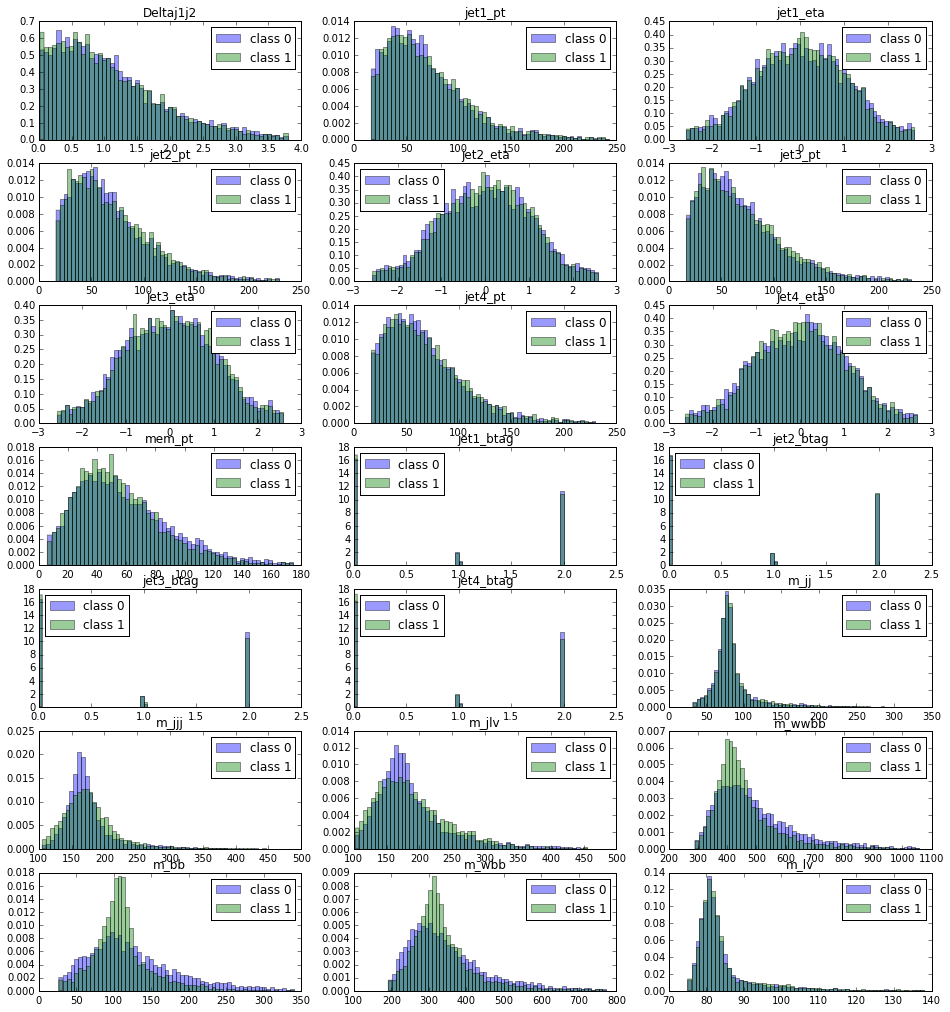

In [11]:
hist_params = {'normed': True, 'bins': 60, 'alpha': 0.4}
# create the figure
plt.figure(figsize=(16, 25))
for n, feature in enumerate(high_level_features):
    # add sub plot on our figure
    plt.subplot(len(features) // 5 + 5, 3, n+1)
    # define range for histograms by cutting 1% of data from both ends
    min_value, max_value = numpy.percentile(data[feature], [1, 99])
    plt.hist(data.ix[data.target.values == 0, feature].values, range=(min_value, max_value), 
             label='class 0', **hist_params)
    plt.hist(data.ix[data.target.values == 1, feature].values, range=(min_value, max_value), 
             label='class 1', **hist_params)
    plt.legend(loc='best')
    plt.title(feature)

### Divide training data into 2 parts 
`train_test_split` function is used to divide into 2 parts to preserve quality overestimating.

In [12]:
training_data, validation_data = train_test_split(data, random_state=11, train_size=0.66)

### Simple knn from `sklearn` training

In [13]:
# from sklearn.neighbors import KNeighborsClassifier
#from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
#tree = DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=20,
#(class_weight=None, criterion='gini', max_depth=20,
#        max_features=21, max_leaf_nodes=50, min_samples_leaf=10,
#                min_samples_split=7, min_weight_fraction_leaf=0.0,
#            random_state=None, splitter='best'
 
tree = GradientBoostingClassifier(init=None, learning_rate=0.4, loss='deviance',
              max_depth=20, max_features=21, max_leaf_nodes=3,
              min_samples_leaf=2, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
tree.fit(training_data[high_level_features],training_data.target)
#knn = KNeighborsClassifier(n_neighbors=6)
#knn.fit(training_data[high_level_features], training_data.target)

GradientBoostingClassifier(init=None, learning_rate=0.4, loss='deviance',
              max_depth=20, max_features=21, max_leaf_nodes=3,
              min_samples_leaf=2, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False)

In [14]:
# predict validation sample (probability for each event)
proba = tree.predict_proba(validation_data[high_level_features])

In [15]:
learning_curve = []
for proba in tree.staged_predict_proba(validation_data[high_level_features]):
    learning_curve.append(roc_auc_score(validation_data.target, proba[:, 1]))

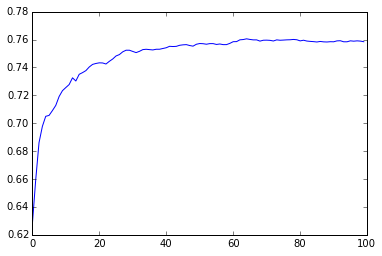

In [16]:
plt.plot(numpy.arange(len(learning_curve)), learning_curve)

In [17]:
proba

array([[ 0.64237375,  0.35762625],
       [ 0.38927036,  0.61072964],
       [ 0.55495698,  0.44504302],
       ..., 
       [ 0.90395514,  0.09604486],
       [ 0.58191286,  0.41808714],
       [ 0.59438778,  0.40561222]])

### Compute quality (ROC AUC) on the validation set (to prevent overestimating quality)

1. feature m_wwbb 18 (0.119812)
2. feature m_jjj 16 (0.097793)
3. feature m_bb 19 (0.089134)
4. feature m_jlv 17 (0.085799)
5. feature m_jj 15 (0.080085)
6. feature jet3_eta 7 (0.066078)
7. feature jet4_btag 14 (0.061809)
8. feature Deltaj1j2 1 (0.057940)
9. feature jet4_eta 9 (0.052258)
10. feature jet1_pt 2 (0.050710)
11. feature jet2_eta 5 (0.050150)


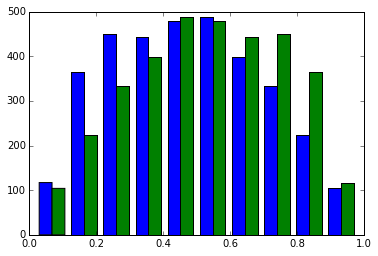

In [39]:
# take probability to be 1 class to compute ROC AUC

plt.hist(proba)
model = SelectFromModel(tree, prefit=True) 
X_new = model.transform(validation_data[high_level_features])
#print X_new
importances = tree.feature_importances_
indices = numpy.argsort(importances)[::-1]
for f in range(X_new.shape[1]):
    print("%d. feature %s %d (%f)" % (f + 1, high_level_features[indices[f]-1],indices[f], importances[indices[f]]))

In [40]:
roc_auc_score(validation_data.target, proba[:, 1])

0.75841723722700061

## Prepare submission to kaggle

In [151]:
# predict test sample
kaggle_proba = tree.predict_proba(test[high_level_features])[:, 1]
kaggle_ids = test.event_id

KeyError: "['Deltajj'] not in index"

In [ ]:
from IPython.display import FileLink
def create_solution(ids, proba, filename='baseline.csv'):
    """saves predictions to file and provides a link for downloading """
    pandas.DataFrame({'event_id': ids, 'prediction': proba}).to_csv('datasets/{}'.format(filename), index=False)
    return FileLink('datasets/{}'.format(filename))
    
create_solution(kaggle_ids, kaggle_proba)